### https://www.kaggle.com/competitions/drawing-with-llms

In [50]:
import kagglehub
import pandas as pd

train_path = kagglehub.competition_download('drawing-with-llms', 'train.csv')
train = pd.read_csv(train_path)

train.head()

,id,description
0,04c411,a starlit night over snow-covered peaks
1,215136,black and white checkered pants
2,3e2bc6,crimson rectangles forming a chaotic grid
3,61d7a8,burgundy corduroy pants with patch pockets and...
4,6f2ca7,orange corduroy overalls


In [51]:
import openai
import pandas as pd
import time
import os
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [52]:
# Set up OpenAI client with your API key
client = openai.OpenAI(api_key=openai_api_key)

# Function to get summary from OpenAI API
def get_summary(text):
    instruction = f"""Generate SVG code to visually represent the following text description, while respecting the given constraints.
    
    <constraints>
    * **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
    * **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
    </constraints>

    <example>
    <description>"A red circle with a blue square inside"</description>
    ```svg
    <svg viewBox="0 0 256 256" width="256" height="256">
      <circle cx="50" cy="50" r="40" fill="red"/>
      <rect x="30" y="30" width="40" height="40" fill="blue"/>
    </svg>
    ```
    </example>

    Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints.
    Focus on a clear and concise representation of the input description within the given limitations. 
    Always provide the complete SVG code with nothing omitted. Never use an ellipsis.

    <description>"{text}"</description>
    """

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Generate an SVG code with the given instruction."},
                {"role": "user", "content": instruction}
            ],
            temperature=0.5,
            max_tokens=1024
        )
        return response.choices[0].message.content.strip()
    
    except Exception as e:
        print(f"Error: {e}")
        return None


In [53]:
from tqdm.auto import tqdm

tqdm.pandas()  # Enable progress bar for pandas
train["svg_code"] = train["description"].progress_apply(get_summary)

100%|███████████████████████████████████████████| 15/15 [00:35<00:00,  2.37s/it]


In [54]:
train['svg_code'] = train['svg_code'].str.replace(r"```svg\n|```", "", regex=True)

In [55]:
train

,id,description,svg_code
0,04c411,a starlit night over snow-covered peaks,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
1,215136,black and white checkered pants,"<svg viewBox=""0 0 100 100"" width=""100"" height=..."
2,3e2bc6,crimson rectangles forming a chaotic grid,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
3,61d7a8,burgundy corduroy pants with patch pockets and...,"<svg viewBox=""0 0 200 200"" width=""200"" height=..."
4,6f2ca7,orange corduroy overalls,"<svg viewBox=""0 0 100 100"" width=""100"" height=..."
5,8066ae,a lighthouse overlooking the ocean,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
6,828a8f,a green lagoon under a cloudy sky,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
7,98f11f,a snowy plain,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
8,9ce3c4,a maroon dodecahedron interwoven with teal thr...,"<svg viewBox=""0 0 100 100"" width=""100"" height=..."
9,a9ecbb,a purple silk scarf with tassel trim,"<svg viewBox=""0 0 200 200"" width=""200"" height=..."


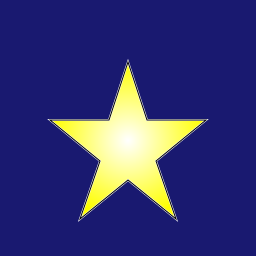

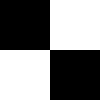

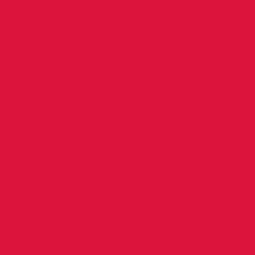

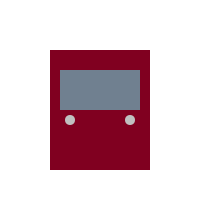

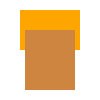

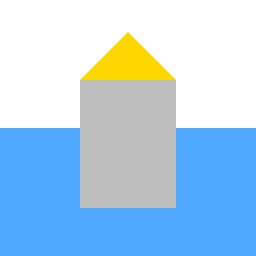

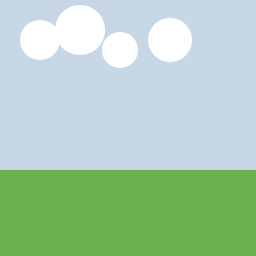

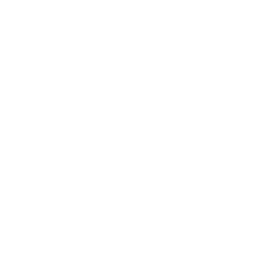

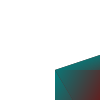

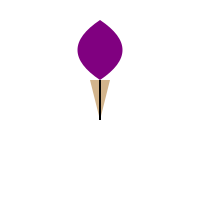

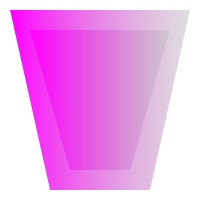

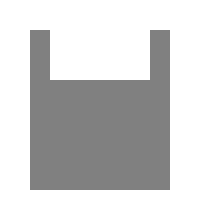

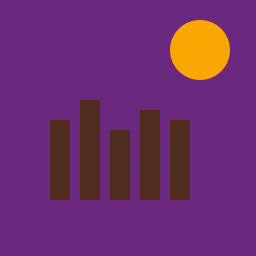

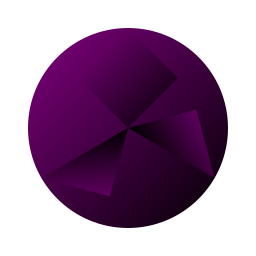

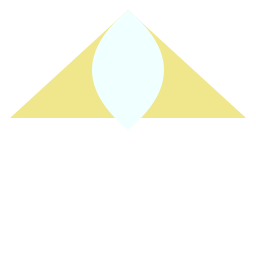

In [56]:
# We can play with our Model and render its SVG output (don't export!)
from IPython.display import SVG, display
for svg in train["svg_code"]:
    #print(svg)
    display(SVG(svg))

In [57]:
from transformers import AutoProcessor, AutoModel
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")

In [79]:
import torch
from PIL import Image
import cairosvg
import os

def svgMetric(prompt, svg):
    try:
        # Convert SVG to PNG
        cairosvg.svg2png(svg, write_to="./tmp/temp.png")
        
        # Open and process the image
        image = Image.open('./tmp/temp.png').convert("RGB")
        texts = ["SVG illustration of " + prompt]
        inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")
        
        # Inference without gradient tracking
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits_per_image = outputs.logits_per_image
        probs = torch.sigmoid(logits_per_image)
        
        # Clean up temporary PNG file
        #os.remove('./tmp/temp.png')
        
        return probs[0][0].item()

    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None




In [83]:
# Using apply to process each row in the DataFrame
train['score'] = train.apply(lambda row: svgMetric(row['description'], row['svg_code']), axis=1)


mean open-ai score: 0.2936446070079304


In [85]:
# Display results
#print(train[['description', 'score']])
print('mean gpt-3.5-turbo score:',train['score'].mean())

mean gpt-3.5-turbo score: 0.2936446070079304


In [86]:
train

,id,description,svg_code,Score,score
0,04c411,a starlit night over snow-covered peaks,"<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.000239,0.000239
1,215136,black and white checkered pants,"<svg viewBox=""0 0 100 100"" width=""100"" height=...",0.007646,0.007646
2,3e2bc6,crimson rectangles forming a chaotic grid,"<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.007120,0.007120
3,61d7a8,burgundy corduroy pants with patch pockets and...,"<svg viewBox=""0 0 200 200"" width=""200"" height=...",0.008671,0.008671
4,6f2ca7,orange corduroy overalls,"<svg viewBox=""0 0 100 100"" width=""100"" height=...",0.000078,0.000078
5,8066ae,a lighthouse overlooking the ocean,"<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.007294,0.007294
6,828a8f,a green lagoon under a cloudy sky,"<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.512742,0.512742
7,98f11f,a snowy plain,"<svg viewBox=""0 0 256 256"" width=""256"" height=...",0.000411,0.000411
8,9ce3c4,a maroon dodecahedron interwoven with teal thr...,"<svg viewBox=""0 0 100 100"" width=""100"" height=...",0.471928,0.471928
9,a9ecbb,a purple silk scarf with tassel trim,"<svg viewBox=""0 0 200 200"" width=""200"" height=...",0.000041,0.000041
